In [2]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [80]:
import glob
from joblib import Parallel, delayed

path_list = glob.glob('../stack/*stack*.gz')
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)
base['first_active_month'].fillna('2017-03', inplace=True)

def concat_stack(path):
    tmp = utils.read_pkl_gzip(path).set_index(key)
    date = re.search(r'/([^/.]*)_stack', path).group(1)
    cv = re.search(r'CV([^/.]*)', path).group(1)
    if 'pred_mean' in tmp.columns:
        tmp = tmp['pred_mean']
        tmp.name =  f"{date}_{cv}"
    else:
        tmp = tmp['prediction']
        tmp.name =  f"{date}_{cv}"
    return tmp

pred_list = Parallel(n_jobs=-1)([delayed(concat_stack)(path) for path in path_list])
df_pred = pd.concat(pred_list, axis=1)
base = base.join(df_pred)

100%|██████████| 3/3 [00:00<00:00, 64.59it/s]


In [ ]:
pd.set_option('max_rows', 200)
from sklearn.metrics import mean_squared_error
#========================================================================
# Part of card_id Score


pred_cols = [col for col in base.columns if col not in ignore_list and col.count('LB')]

def get_fam_score(pred_col):

    base_train = base[~base[target].isnull()].reset_index().fillna(0)
    part_score_list = []
    part_N_list = []
    fam_list = []
    score_list = []
    
    fam_list = sorted(np.unique(list(base_train['first_active_month'].value_counts().index)))

    for fam in fam_list:
        df_part = base_train[base_train['first_active_month']==fam]
        if len(df_part)==0:
            print(fam)
            continue
        part_id_list = df_part[key].values
    
        part_train = base_train.loc[base_train[key].isin(part_id_list), :]
        y_train = part_train[target].values
        
        y_pred = part_train[pred_col].values
        # RMSE
        part_score = np.sqrt(mean_squared_error(y_train, y_pred))

        fam_list.append(fam)
        part_score_list.append(part_score)
        part_N_list.append(len(part_id_list))
    
    df = pd.DataFrame(np.asarray([fam_list, part_score_list, part_N_list]).T)
    df.columns = ['FAM', 'CV', 'N']
    df['name'] = pred_col
    return df
    
fam_score_list = Parallel(n_jobs=-1)([delayed(get_fam_score)(pred_col) for pred_col in pred_cols])

In [ ]:
result = pd.concat(fam_score_list, axis=0)
result['yyyymm'] = result['FAM'].map(lambda x: int(x.replace('-', '')))
result['CV'] = result['CV'].astype('float64')
result = result[result['name']!='0109_223_1-5465657344282366_LB']
result.sort_values(by=['FAM', 'CV'], ascending=True, inplace=True)
df_row = utils.row_number(df=result, level='FAM')

# viz_fam_min = '2012-01'
# bench = df_row[df_row['name']=='0129_102_3-6389228323052527_LB']
# bench = bench[bench['FAM']>=viz_fam_min]
# bench['row_no'] = 'bench'
# viz = df_row[df_row['row_no']<=20]
# viz = viz[viz['FAM']>=viz_fam_min]
# # viz = pd.concat([bench, viz], axis=0, ignore_index=True)

# bench.rename(columns={'CV':'bench', 'name':'bench_name'}, inplace=True)
# viz = viz.merge(bench[['FAM', 'yyyymm', 'bench']], how='inner', on=['FAM', 'yyyymm'])
# viz['diff'] = viz['CV'] - viz['bench']

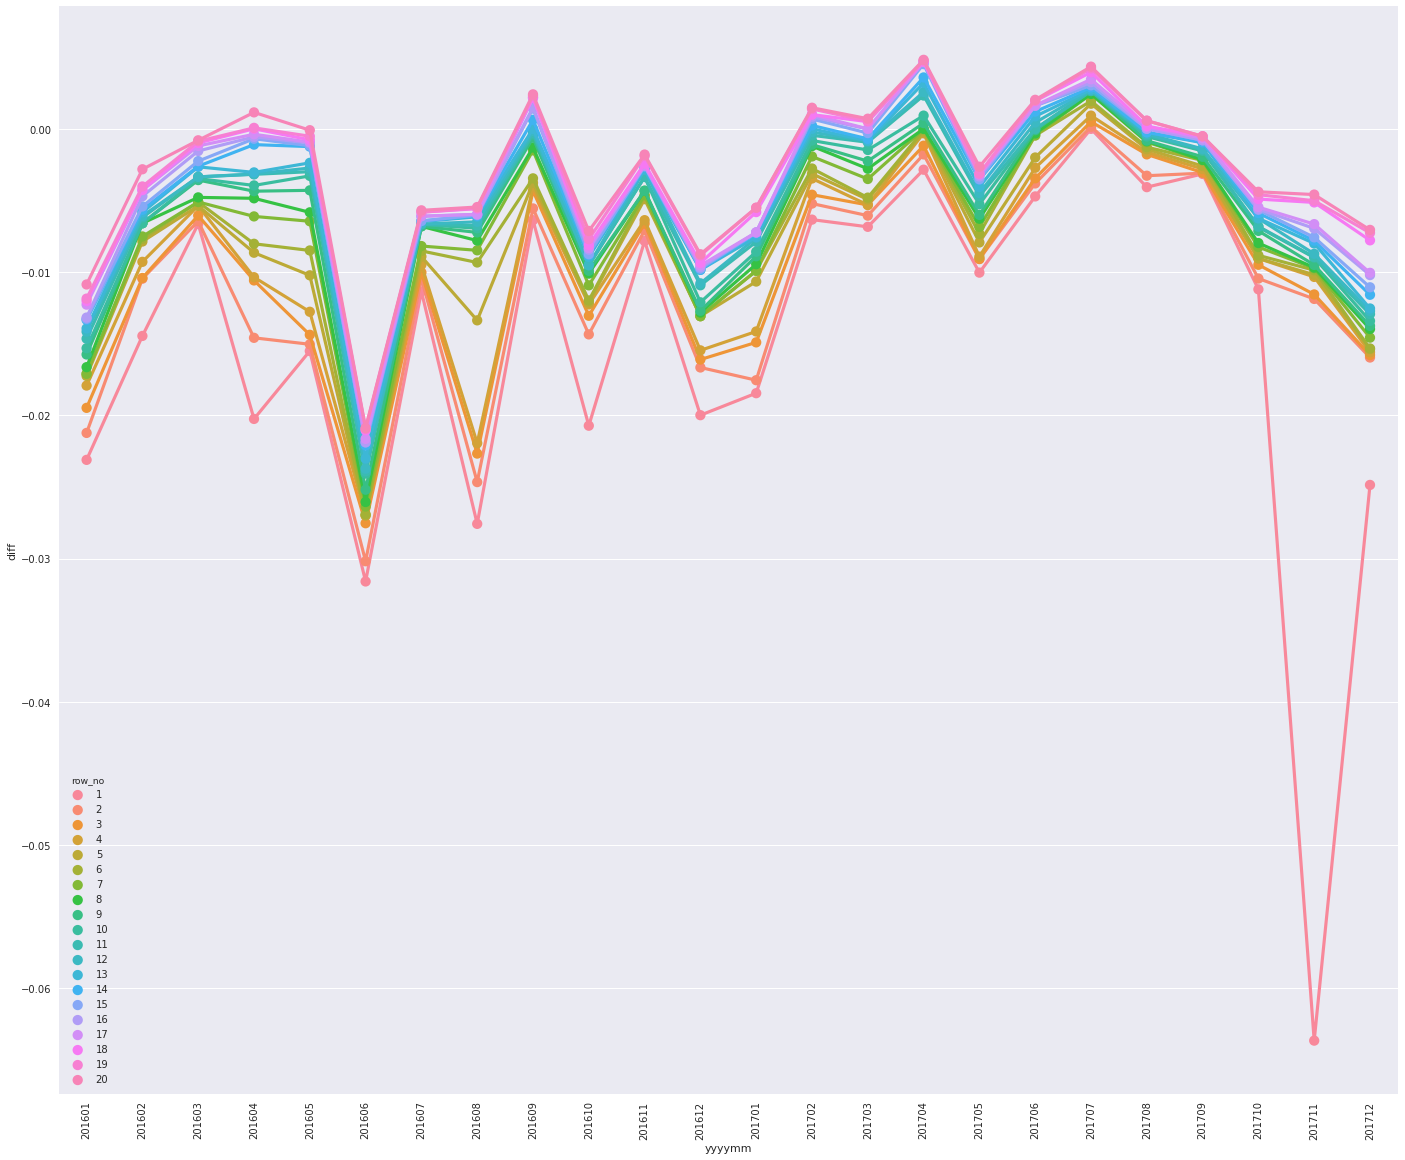

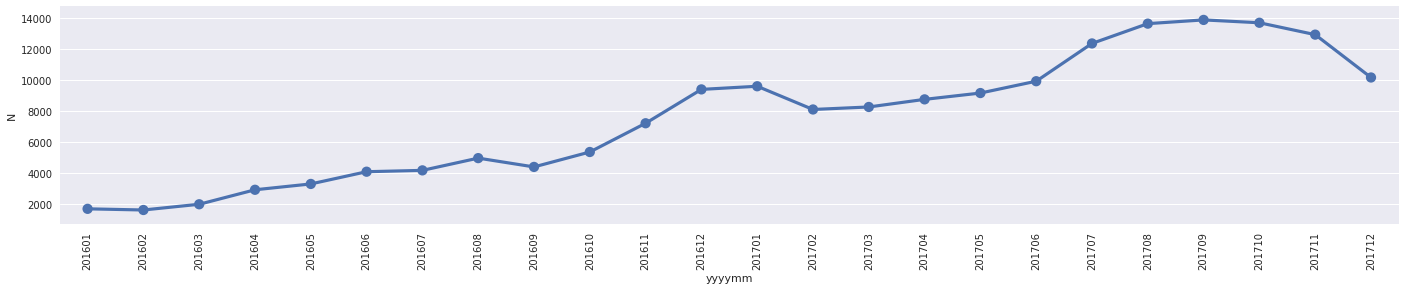

In [7]:
plt.figure(figsize=(24, 20))
sns.pointplot(x="yyyymm", y="diff", hue="row_no", data=viz[viz['yyyymm']>=201601])
plt.xticks(rotation=90)
plt.show()

viz_N = viz[['yyyymm', 'N']].drop_duplicates()
viz_N['N'] = viz_N['N'].astype('int')
sns.color_palette(n_colors=24)
plt.figure(figsize=(24, 4))
sns.pointplot(x="yyyymm", y="N", data=viz_N[viz_N['yyyymm']>=201601])
plt.xticks(rotation=90)
plt.show()

### Stacking

In [ ]:
fam_list = sorted(np.unique(base['first_active_month'].values).tolist())
df_stack = pd.DataFrame()
base_train = base[~base[target].isnull()]

top20 = df_row[df_row['row_no']<=20]

for fam in fam_list:
#     print(fam)
    stack_cols = top20[top20['FAM']==fam]['name'].values.tolist()

    # 対象FAMに絞る
    df_fam = base[['first_active_month'] + stack_cols]
    df_fam = df_fam[df_fam['first_active_month']==fam][stack_cols]
    df_fam['blend'] = df_fam[stack_cols].mean(axis=1)
#     display(df_fam.corr(method='pearson'))
    
    if len(df_stack):
        df_stack = pd.concat([df_stack, df_fam], axis=0)
    else:
        df_stack = df_fam['blend'].copy()
        
#     part_train = base_train.join(df_fam['blend'], how='inner')
    part_train = base[target].to_frame().join(df_fam['blend'], how='inner')
    y_train = part_train[target].values
    y_pred = part_train['blend'].values
    # RMSE
#     try:
#         part_score = np.sqrt(mean_squared_error(y_train, y_pred))
#     except ValueError:
#         print(y_train[:5])
#         print(y_pred[:5])
#         print(part_train[part_train.isnull()].shape)
#         continue
#     print(df_stack.shape)
#     print(f"{fam}: {part_score}")

In [ ]:
df_stack[df_stack['blend'].isnull()]

In [77]:
base_train.loc[null_id, :]

,first_active_month,target,0128_135_3-6446885874930075_LB,0129_091_3-6421820883180707_LB,0130_202_3-0701539463144227_LB,0130_193_5-24805823246483_LB,0130_174_3-310281513340206_LB,0130_131_4-287365410526872_LB,0128_235_3-650037974424863_LB,0112_125_3-649026127427298_LB,0130_113_8-155798454641898_LB,0112_100_3-648712226607567_LB,0130_154_3-64429282597835_LB,0111_084_3-649778904244731_LB,0130_183_6-667250276253759_LB,0129_100_3-641638637113398_LB,0130_220_3-6400503168811924_LB,0130_213_5-444439568899568_LB,0130_213_7-74755365380242_LB,0129_090_3-6429264104369503_LB,0129_095_3-641106016266762_LB,0128_133_3-643366297617407_LB,0111_102_3-6494249648406467_LB,0130_220_3-6367844005886467_LB,0130_180_3-381002346822328_LB,0130_120_4-808329166660606_LB,0130_163_7-652020557732003_LB,0121_071_3-6520267723697666_LB,0128_122_3-6417387771988694_LB,0129_080_3-644452513571249_LB,0129_081_3-6434337612872225_LB,0130_210_8-081060264740016_LB,0109_190_4-103946343538847_LB,0129_082_3-6423406048662748_LB,0114_215_3-6527865752973177_LB,0129_082_3-6461086736452657_LB,0130_192_5-5869409029919925_LB,0130_115_4-433519061810081_LB,0110_210_3-664584024547711_LB,0129_002_3-6498086715716127_LB,0130_175_3-566062858690306_LB,0114_004_3-6505372648747247_LB,0130_141_4-661901629184544_LB,0130_155_3-426516480046737_LB,0129_104_3-6403137386948856_LB,0130_154_3-2526412277627452_LB,0130_174_3-7304007392524396_LB,0111_082_3-648879694681201_LB,0129_092_3-6438192716237765_LB,0130_211_4-412486822066033_LB,0130_165_4-90772381051495_LB,0129_002_3-6471011034364715_LB,0129_092_3-6440084809997373_LB,0115_222_3-649798655247443_LB,0107_012_3-647842318785019_LB,0115_234_3-652639795750401_LB,0130_103_3-7716349301445597_LB,0130_173_3-8055560563741566_LB,0120_200_3-6514966430026154_LB,0130_140_3-8766016994648522_LB,0129_094_3-642461794885702_LB,0114_010_3-6497211097385147_LB,0129_091_3-6426572813958784_LB,0129_085_3-6432164386149766_LB,0130_164_4-1250528593787665_LB,0130_161_4-08795025037205_LB,0109_082_3-6484994493282237_LB,0130_111_4-165154214294814_LB,0130_184_7-917904397766032_LB,0129_083_3-6432021299072446_LB,0130_143_4-642199756624356_LB,0130_163_5-627032636520041_LB,0129_094_3-643330263158923_LB,0130_215_4-391957977434176_LB,0129_105_3-63924831290732_LB,0130_124_4-642152733618808_LB,0112_084_3-649046125233803_LB,0128_121_3-6431692942772687_LB,0130_160_3-4248006894120318_LB,0130_102_3-2299353202981393_LB,0107_092_3-650884719039021_LB,0128_131_3-6393726839122764_LB,0109_102_3-6484994493282237_LB,0110_221_3-6527566399693434_LB,0130_132_3-9292507891210335_LB,0130_190_4-41717957381407_LB,0130_184_7-526536547094926_LB,0112_180_3-649515727422533_LB,0110_230_3-64958566806189_LB,0107_221_3-649821386872066_LB,0112_092_3-649268954801554_LB,0110_222_3-6527566399693425_LB,0129_090_3-643273149809964_LB,0128_131_3-6413716858127954_LB,0128_121_3-6422568532512316_LB,0129_090_3-643037373015832_LB,0130_172_5-412881854104323_LB,0130_110_3-5405213955231942_LB,0128_112_3-6439982330582543_LB,0128_151_3-6401903762222707_LB,...,0130_181_3-3731501716000354_LB,0122_235_3-6503384710582276_LB,0109_191_4-09782224622231_LB,0130_202_3-356798459359767_LB,0130_162_6-712429555178332_LB,0130_111_6-769575728886151_LB,0112_161_3-649133141540562_LB,0130_101_3-2703657019416936_LB,0128_134_3-6409525551362676_LB,0130_115_4-38966022113365_LB,0130_191_5-467872215202722_LB,0115_221_3-6514680644239106_LB,0121_081_3-652021636110317_LB,0109_215_3-5317518544372155_LB,0111_154_3-3530444409955336_LB,0128_123_3-643561659731674_LB,0130_113_7-790361087511494_LB,0129_094_3-6427273143450103_LB,0130_114_5-6928880852191_LB,0130_182_3-3696697841656444_LB,0129_085_3-642836526998495_LB,0130_130_4-205938438906571_LB,0112_163_3-3503452476449724_LB,0130_110_3-4234202748395886_LB,0114_215_3-653008658632465_LB,0110_083_3-6662646410644384_LB,0130_205_6-668490336418685_LB,0129_083_3-642935809014535_LB,0110_211_3-666769302305775_LB,0130_121_5-548004809070973_LB,0128_132_3-6419698340339814_LB,0130_180_3-0869532248915177_LB,0129_094_3-64388744369

In [72]:
import datetime
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())
null_id = df_stack[df_stack['blend'].isnull()].index
sys.exit()

#========================================================================
# Blend CV Score
base_train = base[~base[target].isnull()]
part_train = base_train[target].to_frame().join(df_stack['blend'], how='inner').dropna()
y_train = part_train[target].values
y_pred = part_train['blend'].values
cv_score = np.sqrt(mean_squared_error(y_train, y_pred))
print(cv_score)
#========================================================================

submit = pd.read_csv('../input/sample_submission.csv').set_index(key)
submit[target] = df_stack['blend']
submit_path = f'../submit/{start_time[4:12]}_submit_blender_top20_FAM_model_CV{cv_score}_LB.csv'
display(submit.head())
submit.to_csv(submit_path, index=True)

SystemExit: 

In [28]:
import shutil

path_list = glob.glob('../stack/*.gz')
for p in path_list:
    tmp = utils.read_pkl_gzip(p)
    pred_cols = [col for col in tmp.columns if col.count('pred_mean') or col=='prediction']
    for col in pred_cols:
        try:
            length = tmp.shape[0]
            if length>330000:
                print(p)
                print(col)
                shutil.move(p, '../stack/delete/')
        except ValueError:
            print(p)
            display(tmp.head())
            sys.exit()

KeyboardInterrupt: 